In [1]:
%pip install sentencepiece==0.1.97 # same as silnlp
%pip install nltk==3.7 # same as silnlp
%pip install sacrebleu==2.3.1 # same as silnlp
%pip install rouge_score
%pip install editdistance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sacrebleu
from nltk.translate.gleu_score import sentence_gleu
from nltk.translate.nist_score import corpus_nist
import nltk
from rouge_score import rouge_scorer
import sacrebleu
import editdistance
from nltk.translate.meteor_score import meteor_score

In [3]:
# NLTK data
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cryst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cryst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
path = "C:/mySIL/bloom1_siddi/"     # For Windows
#path = "/Users/laura/llmResearch/preprocessed/"
language = "siddi"
dataset = "test"

In [14]:
with open(path + "/" + "unsloth_seallm_allTrainingData_1epoch_" + language + "_" + dataset + "_generated.txt", "r", encoding="utf-8") as file:
    trg_predictions = file.readlines()
with open(path + language + "/" + dataset + ".trg.detok.txt", "r", encoding="utf-8") as file:
    trg = file.readlines()
with open(path + language + "/" + dataset + ".src.detok.txt", "r", encoding="utf-8") as file:
    src = file.readlines() 

In [ ]:
print(src[0])
print(trg[0])
print(trg_predictions[0])

In [ ]:
# automatically remove prompt from results
#trg_predictions = [i[i.find(":")+2:] for i in trg_predictions] #32

for i in range(len(trg_predictions)):
  source_sentence = src[i][:-1] #remove new line character from the end of the source sentence
  prediction = trg_predictions[i]
  print(source_sentence)
  print(prediction)
  
  if prediction[:len(source_sentence)]==source_sentence: #prediction repeats the source sentence
    trg_predictions[i] = prediction[len(source_sentence)+1:] #remove source sentence from prediction
    print(trg_predictions[i])
  break

In [6]:
pair_sys = trg_predictions
pair_refs = [trg]

scores = {}

bleu_score = sacrebleu.corpus_bleu(pair_sys,pair_refs,lowercase=True,tokenize="13a")
scores["BLEU"] = bleu_score.score

chrf3_score = sacrebleu.corpus_chrf(pair_sys, pair_refs, char_order=6, beta=3, remove_whitespace=True)
scores["chrF3"] = chrf3_score.score

chrfp_score = sacrebleu.corpus_chrf(pair_sys, pair_refs, char_order=6, beta=3, word_order=1, remove_whitespace=True, eps_smoothing=True)
scores["chrF3+"] = chrfp_score.score

chrfpp_score = sacrebleu.corpus_chrf(pair_sys, pair_refs, char_order=6, beta=3, word_order=2, remove_whitespace=True, eps_smoothing=True)
scores["chrF3++"] = chrfpp_score.score

spbleu_score = sacrebleu.corpus_bleu(pair_sys, pair_refs, lowercase=True,tokenize="flores200",)
scores["spBLEU"] = spbleu_score.score

In [7]:
len(trg_predictions)

250

In [8]:
scores

{'BLEU': 1.0125883387333812,
 'chrF3': 24.50296153946874,
 'chrF3+': 23.127022073303625,
 'chrF3++': 20.522725877546264,
 'spBLEU': 9.012866694421035}

In [9]:

# METEOR score to evaluate trnaslation quality (synonyms, alignment, stemming, etc.)
def compute_meteor(translations, references):
    scores = [meteor_score([ref.split()], trans.split()) for trans, ref in zip(translations, references)]
    return sum(scores) / len(scores)

# ROUGE score is sensitive to missing words which is useful for identifying missing words from translations
def compute_rouge(translations, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = [scorer.score(ref, trans) for trans, ref in zip(translations, references)]
    averaged_scores = {key: sum(score[key].fmeasure for score in scores) / len(scores) for key in scores[0]}
    return averaged_scores

# GLEU score to evaluate sentence level quality
def compute_gleu(translations, references):
    scores = [sentence_gleu([ref.split()], trans.split()) for trans, ref in zip(translations, references)]
    return sum(scores) / len(scores)

# TER score to evalute missing words, segment alignment, etc.
def compute_ter(translations, references):
    ter_score = sacrebleu.corpus_ter(translations, references).score
    return ter_score

# Edit Distance to identify misspelled words, punctuation, missing/extra word checking
def compute_edit_distance(translations, references):
    distances = [editdistance.eval(trans, ref) for trans, ref in zip(translations, references)]
    return sum(distances) / len(distances)

# precision and recall to measure how well the model captures keywords
def compute_precision_recall(translations, references):
    precisions = []
    recalls = []
    for trans, ref in zip(translations, references):
        reference_tokens = set(ref.split())
        translation_tokens = set(trans.split())
        common_tokens = reference_tokens & translation_tokens
        precision = len(common_tokens) / len(translation_tokens)
        recall = len(common_tokens) / len(reference_tokens)
        precisions.append(precision)
        recalls.append(recall)
    return sum(precisions) / len(precisions), sum(recalls) / len(recalls)

# NIST score (weighting rare n-grams more heavily)
def compute_nist(translations, references):
    tokenized_translations = [trans.split() for trans in translations]
    tokenized_references = [[ref.split()] for ref in references]
    nist_score = corpus_nist(tokenized_references, tokenized_translations, n=5)  # Use n-gram size of 5
    return nist_score


# Compute scores  
scores["METEOR"] = compute_meteor(pair_sys, pair_refs[0])
rouge_scores = compute_rouge(pair_sys, pair_refs[0])
for key, value in rouge_scores.items():
    scores[f"ROUGE-{key.upper()}"] = value
scores["GLEU"] = compute_gleu(pair_sys, pair_refs[0])
scores["TER"] = compute_ter(pair_sys, pair_refs[0])
scores["Edit Distance"] = compute_edit_distance(pair_sys, pair_refs[0])
precision, recall = compute_precision_recall(pair_sys, pair_refs[0])
scores["Precision"] = precision
scores["Recall"] = recall
scores["NIST"] = compute_nist(pair_sys, pair_refs[0])

# Print the computed scores
for score_name, score_value in scores.items():
    print(f"{score_name}: {score_value}")



BLEU: 1.0125883387333812
chrF3: 24.50296153946874
chrF3+: 23.127022073303625
chrF3++: 20.522725877546264
spBLEU: 9.012866694421035
METEOR: 0.06889183786740613
ROUGE-ROUGE1: 0.0
ROUGE-ROUGE2: 0.0
ROUGE-ROUGEL: 0.0
GLEU: 0.0311018701824976
TER: 2494.772856871317
Edit Distance: 132.396
Precision: 0.1884869208681768
Recall: 0.1154497976416811
NIST: 0.7827115456837547


In [10]:
import json

def save_to_jsonl(file_path, data, language):

    data_with_language_name = {"language": language}
    data_with_language_name.update(data)
    
    # Save scores to JSONL file and not overwritting existing rows
    with open(file_path, 'a') as file:
        file.write(json.dumps(data_with_language_name) + "\n")

data = scores
file_path = dataset + "_scores.jsonl"
save_to_jsonl(file_path, data, language)

Score_v4:  Added sentence level scores and then plot its distribution 

In [11]:
# Input list of reference lists
pair_refs = [[ref.strip()] for ref in trg]
pair_sys = [pred.strip() for pred in trg_predictions]

bleu_scores = []
chrf3_scores = []
chrfp_scores = []
chrfpp_scores = []
spbleu_scores = []

# Calculate individual sentence-level scores
for sys, ref in zip(pair_sys, pair_refs):
    bleu_score = sacrebleu.sentence_bleu(sys, ref, lowercase=True, tokenize="13a").score
    chrf3_score = sacrebleu.sentence_chrf(sys, ref, char_order=6, beta=3, remove_whitespace=True).score
    chrfp_score = sacrebleu.sentence_chrf(sys, ref, char_order=6, beta=3, word_order=1, remove_whitespace=True, eps_smoothing=True).score
    chrfpp_score = sacrebleu.sentence_chrf(sys, ref, char_order=6, beta=3, word_order=2, remove_whitespace=True, eps_smoothing=True).score
    spbleu_score = sacrebleu.sentence_bleu(sys, ref, lowercase=True, tokenize="flores200").score

    bleu_scores.append(bleu_score)
    chrf3_scores.append(chrf3_score)
    chrfp_scores.append(chrfp_score)
    chrfpp_scores.append(chrfpp_score)
    spbleu_scores.append(spbleu_score)

# Calculate average scores 
scores = {
    "BLEU": sum(bleu_scores) / len(bleu_scores),
    "chrF3": sum(chrf3_scores) / len(chrf3_scores),
    "chrF3+": sum(chrfp_scores) / len(chrfp_scores),
    "chrF3++": sum(chrfpp_scores) / len(chrfpp_scores),
    "spBLEU": sum(spbleu_scores) / len(spbleu_scores)
}

# Average scores
print(scores)


{'BLEU': 2.8087313594492667, 'chrF3': 24.6860154311713, 'chrF3+': 23.280041535597558, 'chrF3++': 20.66174995276741, 'spBLEU': 8.788591897867912}


In [12]:
%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


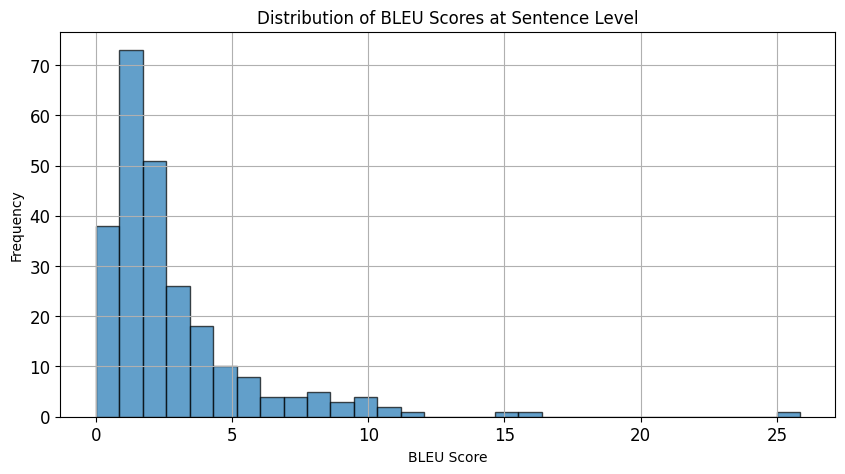

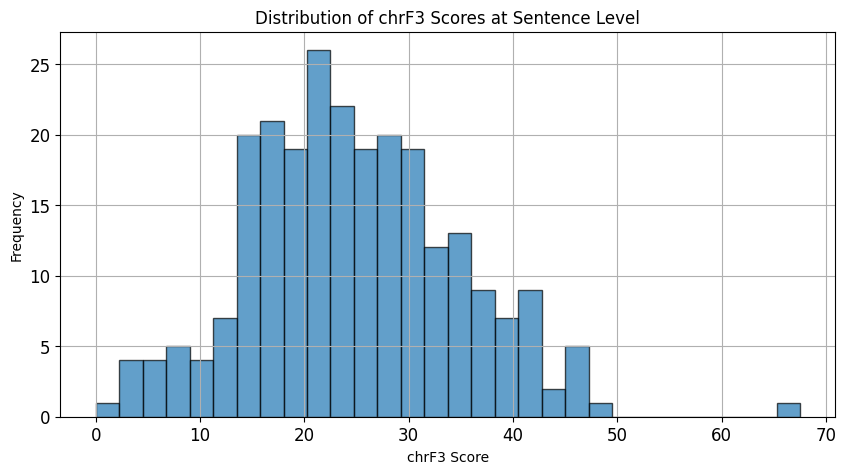

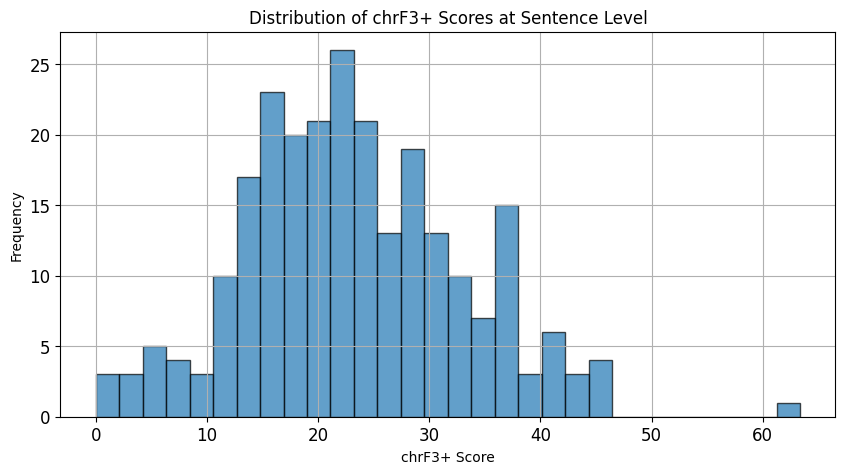

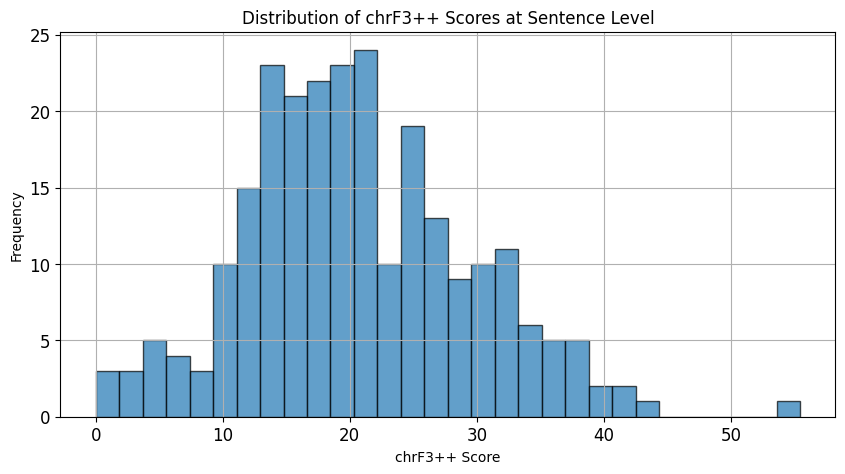

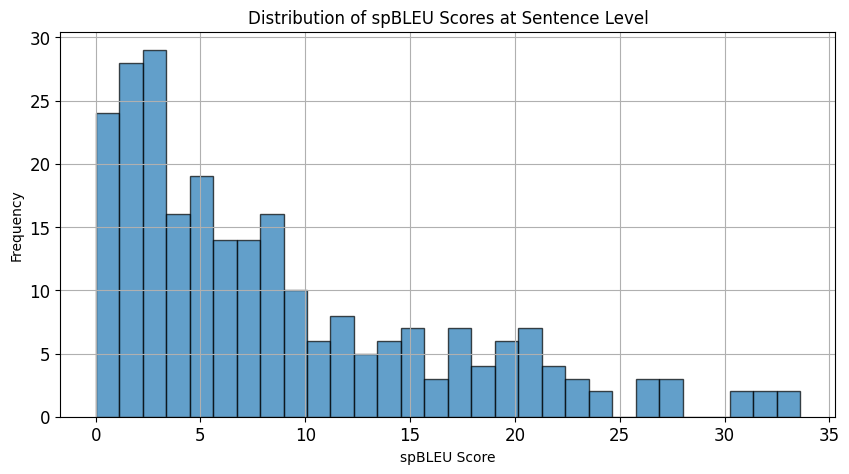

In [13]:
import matplotlib.pyplot as plt

# Define a function to plot histograms
def plot_histogram(data, title, xlabel, ylabel, bins=30):
    plt.figure(figsize=(10, 5))
    plt.hist(data, bins=bins, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.show()

# BLEU Score Distribution
plot_histogram(bleu_scores, 'Distribution of BLEU Scores at Sentence Level', 'BLEU Score', 'Frequency')

# chrF3 Score Distribution
plot_histogram(chrf3_scores, 'Distribution of chrF3 Scores at Sentence Level', 'chrF3 Score', 'Frequency')

# chrF3+ Score Distribution
plot_histogram(chrfp_scores, 'Distribution of chrF3+ Scores at Sentence Level', 'chrF3+ Score', 'Frequency')

# chrF3++ Score Distribution
plot_histogram(chrfpp_scores, 'Distribution of chrF3++ Scores at Sentence Level', 'chrF3++ Score', 'Frequency')

# spBLEU Score Distribution
plot_histogram(spbleu_scores, 'Distribution of spBLEU Scores at Sentence Level', 'spBLEU Score', 'Frequency')
